In [1]:
#Assignment2_Student_Grader

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [2]:
#Read/load student information .json file to create student database
#creating
with open('student_information.json', 'r') as file:
    student_data = json.load(file)

'''
Randomly generate 100 students using the combination of available usernames and last names
Randomly generate a BU student ID with prefix U using the max and min range
Randomly assign their GPAs based on the GPA field (Gaussian number in the file)
Have 10 of the worse drop out of the class/unenroll
Use Pandas dataframe to store all this data into a database give all fields

'''
# Extract data from the JSON
number_of_students = student_data['number']
first_names = student_data['first_names']
last_names = student_data['last_names']
gpa_range = student_data['GPA']['range']
gpa_mean = 3.0  # Mean and standard deviation are implied in the dist
gpa_std_dev = 0.5
status_distribution = student_data['status']
id_min = student_data['student_id']['min']
id_max = student_data['student_id']['max']
id_prefix = student_data['student_id']['prefix']

# Generate random student data without using for loops
def generate_students(num_students):
    # Generate random first and last names
    first_name_series = np.random.choice(first_names, num_students)
    last_name_series = np.random.choice(last_names, num_students)
    
    # Generate random student IDs
    student_ids = np.random.choice(np.arange(id_min, id_max + 1), num_students, replace = False)
    student_id_series = id_prefix + student_ids.astype(str)
    
    # Generate GPA using Gaussian distribution and clip to the given range
    gpas = np.random.normal(gpa_mean, gpa_std_dev, num_students)
    gpa_series = np.clip(gpas, gpa_range[0], gpa_range[1]).round(2)
    
    # Generate random status based on distribution
    statuses = np.random.choice([status[1] for status in status_distribution], num_students, p = [status[0] for status in status_distribution])
    
    # Create DataFrame using the generated data
    df = pd.DataFrame({
        'Student ID': student_id_series,
        'First Name': first_name_series,
        'Last Name': last_name_series,
        'GPA': gpa_series,
        'Status': statuses
    })
    
    return df

# Generate the students
students_df = generate_students(number_of_students)

# Save to CSV file
students_df.to_csv('students_db.csv', index=False)

In [61]:
# Creating grading distribution and curve for assessment types

'''
Using assessment_information.json as a framwork to randomly generate and organize different assessment types:
- homework
- laboratory
- quiz
- test
- exam
- project
- participation

For each assessment assign it their properties:
- the number of each component
- the total grade for this component, or, an array of values for each component
- the maximum and minimum grades for this assignment
- completion rates for "Enrolled" and "Dropped" students
- a distribution of grades, specified as a mixed Gaussian, like this: weight, mean, STD

Assign each student the grade for each of these assessment types with:
- the student ID
- the grade

- Did not take assessment, or got everything wrong: grade assigned = 0
- Excused absences: Assign excused state, grade based on attempted assessments
- Unexcused absences: 0
- Dropped out students: Assigned Dropped State

Generate a csv file for each assessment as a database for each students' grades
'''

'\nUsing assessment_information.json as a framwork to randomly generate and organize different assessment types:\n- homework\n- laboratory\n- quiz\n- test\n- exam\n- project\n- participation\n\nFor each assessment assign it their properties:\n- the number of each component\n- the total grade for this component, or, an array of values for each component\n- the maximum and minimum grades for this assignment\n- completion rates for "Enrolled" and "Dropped" students\n- a distribution of grades, specified as a mixed Gaussian, like this: weight, mean, STD\n\nAssign each student the grade for each of these assessment types with:\n- the student ID\n- the grade\n\n- Did not take assessment, or got everything wrong: grade assigned = 0\n- Excused absences: Assign excused state, grade based on attempted assessments\n- Unexcused absences: 0\n- Dropped out students: Assigned Dropped State\n\nGenerate a csv file for each assessment as a database for each students\' grades\n'

In [62]:
# Convert student csv to readable df
students_db = pd.read_csv('students_db.csv')

# Function to handle excused or unexcused absences and unenrolled students
def apply_student_states(statuses, num_students, num_labs):
    # Generate random numbers to represent absences and dropouts
    random_numbers = np.random.random((num_students, num_labs))
    
    # Apply the student states based on the random numbers
    excused_absence_mask = (random_numbers < 0.05)  # 5% excused absence for individual labs
    unexcused_absence_mask = (random_numbers >= 0.05) & (random_numbers < 0.10)  # 5% unexcused absence for individual labs
    enrolled_mask = (statuses == "Enrolled").to_numpy()  # Convert to NumPy array for proper indexing
    
    return excused_absence_mask, unexcused_absence_mask, enrolled_mask

In [63]:
def generate_participation(students_df, num_participations=13):
    num_students = len(students_df)
    
    # Generate participation grades (either 100% or 0%)
    participation_grades = np.random.choice([100, 0], (num_students, num_participations), p=[0.95, 0.05]).astype(float)
    
    # Handle student states (excused for some participations, unexcused for others)
    statuses = students_df['Status']
    excused_absence_mask, unexcused_absence_mask, enrolled_mask = apply_student_states(statuses, num_students, num_participations)
    
    # Set excused students' participation grades to NaN for excused participations
    participation_grades[excused_absence_mask] = np.nan
    
    # Set unexcused students' participation grades to 0 for unexcused participations
    participation_grades[unexcused_absence_mask & enrolled_mask[:, np.newaxis]] = 0
    
    # Calculate the mean grade for each student, ignoring NaN values
    mean_grades = np.nanmean(participation_grades, axis=1)
    
    # Create a DataFrame and assign column names
    participation_columns = [f'Participation_{i+1}' for i in range(num_participations)]
    participation_df = pd.DataFrame(participation_grades, columns=participation_columns)
    
    # Insert student IDs and mean grades into the DataFrame
    participation_df.insert(0, 'Last Name', students_df['Last Name'])
    participation_df.insert(1, 'First Name', students_df['First Name'])
    participation_df.insert(2, 'Student ID', students_df['Student ID'])
    participation_df['Mean Grade'] = np.round(mean_grades, 1)
    
    return participation_df

# Generate CSV File for Participation
participation_df = generate_participation(students_db)
participation_df.to_csv('participation_grades.csv', index=False)


In [64]:
def generate_homework(students_df, num_homeworks=10, max_grade=100, min_grade=0, mean = 88, std = 8):
    num_students = len(students_df)
    
    # Generate homework grades Gaussian a uniform distribution between min and max
    homework_grades = np.random.normal(mean, std, (num_students, num_homeworks)).astype(float)
    
    # Round grades to 1 decimal place
    homework_grades = np.round(homework_grades, 1)
    
    # For dropped students, cap the maximum grades (90%)
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    homework_grades[dropped_mask] = np.clip(homework_grades[dropped_mask], min_grade, 90)  # Ensure dropped students get lower grades
    
    # Remove last 3 homework grades for dropped students
    homework_grades[dropped_mask, -3:] = np.nan  # Set last 3 homeworks as NaN
    
    # Handle student states (excused for some homeworks, unexcused for others)
    statuses = students_df['Status']
    excused_absence_mask, unexcused_absence_mask, enrolled_mask = apply_student_states(statuses, num_students, num_homeworks)
    
    # Set excused students' homework grades to NaN for excused homeworks
    homework_grades[excused_absence_mask] = np.nan
    
    # Set unexcused students' homework grades to 0 for unexcused homeworks
    homework_grades[unexcused_absence_mask & enrolled_mask[:, np.newaxis]] = 0
    
    # Calculate the mean grade for each student, ignoring NaN values
    mean_grades = np.nanmean(homework_grades, axis=1)
    
    # Create a DataFrame and assign column names
    homework_columns = [f'Homework_{i+1}' for i in range(num_homeworks)]
    homework_df = pd.DataFrame(homework_grades, columns=homework_columns)
    
    # Insert student IDs and mean grades into the DataFrame
    homework_df.insert(0, 'Last Name', students_df['Last Name'])
    homework_df.insert(1, 'First Name', students_df['First Name'])
    homework_df.insert(2, 'Student ID', students_df['Student ID'])
    homework_df['Mean Grade'] = np.round(mean_grades, 1)
    
    return homework_df

# Generate CSV File for Homework
homework_df = generate_homework(students_db)
homework_df.to_csv('homework_grades.csv', index=False)


In [65]:
def generate_quiz(students_df, num_quizzes=13, max_grade=100, min_grade=0, mean=93, std=6):
    num_students = len(students_df)
    
    # Generate quiz grades using a Gaussian distribution
    quiz_grades = np.random.normal(mean, std, (num_students, num_quizzes)).astype(float)
    
    # Clip grades between min and max
    quiz_grades = np.clip(quiz_grades, min_grade, max_grade)
    
    # Round grades to 1 decimal place
    quiz_grades = np.round(quiz_grades, 1)
    
    # Identify dropped students
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    
    # Remove last 3 quiz grades for dropped students
    quiz_grades[dropped_mask, -3:] = np.nan  # Set last 3 quizzes as NaN
    
    # Handle student states (excused for some quizzes, unexcused for others)
    statuses = students_df['Status']
    excused_absence_mask, unexcused_absence_mask, enrolled_mask = apply_student_states(statuses, num_students, num_quizzes)
    
    # Set excused students' quiz grades to NaN for excused quizzes
    quiz_grades[excused_absence_mask] = np.nan
    
    # Set unexcused students' quiz grades to 0 for unexcused quizzes
    quiz_grades[unexcused_absence_mask & enrolled_mask[:, np.newaxis]] = 0
    
    # Calculate the mean grade for each student, ignoring NaN values
    mean_grades = np.nanmean(quiz_grades, axis=1)
    
    # Create a DataFrame and assign column names
    quiz_columns = [f'Quiz_{i+1}' for i in range(num_quizzes)]
    quiz_df = pd.DataFrame(quiz_grades, columns=quiz_columns)
    
    # Insert student IDs and mean grades into the DataFrame
    quiz_df.insert(0, 'Last Name', students_df['Last Name'])
    quiz_df.insert(1, 'First Name', students_df['First Name'])
    quiz_df.insert(2, 'Student ID', students_df['Student ID'])
    quiz_df['Mean Grade'] = np.round(mean_grades, 1)
    
    return quiz_df

# Generate CSV File for Quiz
quiz_df = generate_quiz(students_db)
quiz_df.to_csv('quiz_grades.csv', index=False)

In [66]:
def generate_project(students_df, num_projects=8, max_grade=100, min_grade=0, mean=90, std=14):
    num_students = len(students_df)
    
    # Generate project grades using a Gaussian distribution
    project_grades = np.random.normal(mean, std, (num_students, num_projects)).astype(float)
    
    # Clip grades between min and max
    project_grades = np.clip(project_grades, min_grade, max_grade)
    
    # For dropped students, cap the maximum grades (80%)
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    project_grades[dropped_mask] = np.clip(project_grades[dropped_mask], min_grade, 80)  # Ensure dropped students get lower grades
    
    # Identify dropped students
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    
    # Remove last 3 lab grades for dropped students
    project_grades[dropped_mask, -2:] = np.nan  # Set last 3 quizzes as NaN
    
    # Round grades to 1 decimal place
    project_grades = np.round(project_grades, 1)
    
    # Handle student states (excused for some projects, unexcused for others)
    statuses = students_df['Status']
    excused_absence_mask, unexcused_absence_mask, enrolled_mask = apply_student_states(statuses, num_students, num_projects)
    
    # Set excused students' project grades to NaN for excused projects
    project_grades[excused_absence_mask] = np.nan
    
    # Set unexcused students' project grades to 0 for unexcused projects
    project_grades[unexcused_absence_mask & enrolled_mask[:, np.newaxis]] = 0
    
    # Calculate the mean grade for each student, ignoring NaN values
    mean_grades = np.nanmean(project_grades, axis=1)
    
    # Create a DataFrame and assign column names
    project_columns = [f'Project_{i+1}' for i in range(num_projects)]
    project_df = pd.DataFrame(project_grades, columns=project_columns)
    
    # Insert student IDs and mean grades into the DataFrame
    project_df.insert(0, 'Last Name', students_df['Last Name'])
    project_df.insert(1, 'First Name', students_df['First Name'])
    project_df.insert(2, 'Student ID', students_df['Student ID'])
    project_df['Mean Grade'] = np.round(mean_grades, 1)
    
    return project_df

# Generate CSV File for Projects
project_df = generate_project(students_db)
project_df.to_csv('project_grades.csv', index=False)

In [67]:
# Updated Lab grades generation function (No For Loops, with 0 grades and mean computation)
def generate_lab(students_df, num_labs=8, max_grade=100, min_grade=0, mean=88, std=12):
    num_students = len(students_df)
    
    # Generate lab grades using a Gaussian distribution
    lab_grades = np.random.normal(mean, std, (num_students, num_labs)).astype(float)
    
    # Clip grades between min and max
    lab_grades = np.clip(lab_grades, min_grade, max_grade)
    
    # Identify dropped students
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    
    # Remove last 2 lab grades for dropped students
    lab_grades[dropped_mask, -2:] = np.nan  # Set last 2 labs as NaN
    
    # For dropped students, cap the maximum grades (80%)
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    lab_grades[dropped_mask] = np.clip(lab_grades[dropped_mask], min_grade, 80)  # Ensure dropped students get lower grades
    
    # Round grades to 1 decimal place
    lab_grades = np.round(lab_grades, 1)
    
    # Handle student states (excused for some labs, unexcused for others)
    statuses = students_df['Status']
    excused_absence_mask, unexcused_absence_mask, enrolled_mask = apply_student_states(statuses, num_students, num_labs)
    
    # Set excused students' lab grades to NaN for excused labs
    lab_grades[excused_absence_mask] = np.nan
    
    # Set unexcused students' lab grades to 0 for unexcused labs
    lab_grades[unexcused_absence_mask & enrolled_mask[:, np.newaxis]] = 0  # Broadcasting for unexcused absence
    
    # Calculate the mean grade for each student, ignoring NaN values
    mean_grades = np.nanmean(lab_grades, axis=1)
    
    # Create a DataFrame and assign column names without using loops
    lab_columns = [f'Lab_{i+1}' for i in range(num_labs)]
    lab_df = pd.DataFrame(lab_grades, columns=lab_columns)
    
    # Insert student IDs and mean grades into the DataFrame
    lab_df.insert(0, 'Student ID', students_df['Student ID'])
    lab_df['Mean Grade'] = np.round(mean_grades, 1)  # Round the mean grades to 1 decimal point
    
    return lab_df

# Generate CSV File for Labs
lab_df = generate_lab(students_db)
lab_df.to_csv('lab_grades.csv', index=False)

In [68]:
def generate_test(students_df, num_tests=2, max_grade=100, min_grade=0, mean=88, std=18):
    num_students = len(students_df)
    
    # Generate test grades using a Gaussian distribution
    test_grades = np.random.normal(mean, std, (num_students, num_tests)).astype(float)
    
    # Clip grades between min and max
    test_grades = np.clip(test_grades, min_grade, max_grade)
    
    # For dropped students, cap the maximum grades (70%)
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    test_grades[dropped_mask] = np.clip(test_grades[dropped_mask], min_grade, 70)  # Ensure dropped students get lower grades
    
    # Round grades to 1 decimal place
    test_grades = np.round(test_grades, 1)
    
    # Handle student states (excused for some tests, unexcused for others)
    statuses = students_df['Status']
    excused_absence_mask, unexcused_absence_mask, enrolled_mask = apply_student_states(statuses, num_students, num_tests)
    
    # Set excused students' test grades to NaN for excused tests
    test_grades[excused_absence_mask] = np.nan
    
    # Set unexcused students' test grades to 0 for unexcused tests
    test_grades[unexcused_absence_mask & enrolled_mask[:, np.newaxis]] = 0
    
    # Calculate the mean grade for each student, ignoring NaN values
    mean_grades = np.nanmean(test_grades, axis=1)
    
    # Create a DataFrame and assign column names
    test_columns = [f'Test_{i+1}' for i in range(num_tests)]
    test_df = pd.DataFrame(test_grades, columns=test_columns)
    
    # Insert student IDs and mean grades into the DataFrame
    test_df.insert(0, 'Last Name', students_df['Last Name'])
    test_df.insert(1, 'First Name', students_df['First Name'])    
    test_df.insert(2, 'Student ID', students_df['Student ID'])
    test_df['Mean Grade'] = np.round(mean_grades, 1)
    
    return test_df

# Generate CSV File for Tests
test_df = generate_test(students_db)
test_df.to_csv('test_grades.csv', index=False)

C:\Users\josh2\AppData\Local\Temp\ipykernel_15380\2670207144.py:28: RuntimeWarning: Mean of empty slice
  mean_grades = np.nanmean(test_grades, axis=1)


In [69]:
def generate_exam(students_df, max_grade=100, min_grade=0, mean=82, std=16):
    num_students = len(students_df)
    
    # Generate exam grades using a Gaussian distribution
    exam_grades = np.random.normal(mean, std, num_students).astype(float)
    
    # Clip grades between min and max
    exam_grades = np.clip(exam_grades, min_grade, max_grade)
    
    # Round grades to 1 decimal place
    exam_grades = np.round(exam_grades, 1)
    
    # Identify dropped students
    dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    
    # Set dropped students' exam grades to NaN for excused exams
    exam_grades[dropped_mask.flatten()] = np.nan
    
    # Create a DataFrame for the exam grades
    exam_df = pd.DataFrame({
        'Last Name' : students_df['Last Name'],
        'First Name': students_df['First Name'],
        'Student ID': students_df['Student ID'],
        'Final Exam': exam_grades
    })
    
    return exam_df

# Generate CSV File for Exam
exam_df = generate_exam(students_db)
exam_df.to_csv('exam_grades.csv', index=False)

In [70]:
#Final Grading and Grading Algorithm/GPA Assigner/Scale
'''
GPA Assignment scale
A = >= 92.5%, 4.0/4.0
A- = >= 90%, < 92.5%, 3.7/4.0 (3 + 2/3)
B+ = >= 87.5%, < 90%, 3.3/4.0 (3 + 1/3)
B = >= 82.5%, < 87.5%, 3.0/4.0
B- = >= 80%, < 82.5%, 2.7/4.0 (2 + 2/3)
C+ = >= 77.5%, < 80%, 2.3/4.0 (2 +1/3)
C = >= 72.5%, < 77.5%, 2.0/4.0
C- = >= 70%, < 72.5%, 1.7/4.0 (1 + 2/3)
D = >= 60%, < 70%, 1.0/4.0 (1 + 1/3)
F = < 60%, 0.0
'''
'''
Weight of assessments:
- Participation: 5%
- Quiz: 10%
- Homework: 10%
- Labs: 10%
- Projects: 15%
- Tests: 30%
- Exam: 20%
'''
'''
Computing Final Grade %:
(0.05 * Mean Participation Grade) + (0.1 * Mean Quiz Grade) + (0.1 * Mean Homework Grade) + (0.1 * Mean Lab Grade) + (0.15 * Mean Project Grade) + (0.3 * Mean Test Grade) + (0.2 * Exam Grade)
'''

'\nComputing Final Grade %:\n(0.05 * Mean Participation Grade) + (0.1 * Mean Quiz Grade) + (0.1 * Mean Homework Grade) + (0.1 * Mean Lab Grade) + (0.15 * Mean Project Grade) + (0.3 * Mean Test Grade) + (0.2 * Exam Grade)\n'

In [71]:
# GPA Assigner Function
def compute_final_gpa(students_df, participation_df, quiz_df, homework_df, lab_df, project_df, test_df, exam_df):
    
    merged_df = pd.DataFrame()
    
    merged_df.insert(0, 'Last Name', students_df['Last Name'])
    merged_df.insert(1, 'First Name', students_df['First Name'])
    merged_df.insert(2, 'Student ID', students_df['Student ID'])
    merged_df.insert(3, 'Enrolled Status', students_df['Status'])

    # Merge each DataFrame, ensuring proper suffixes for each assessment type
    merged_df = merged_df.merge(participation_df[['Student ID', 'Mean Grade']], on='Student ID', how='left').rename(columns={'Mean Grade': 'Participation Grades, 5%'})
    merged_df = merged_df.merge(quiz_df[['Student ID', 'Mean Grade']], on='Student ID', how='left').rename(columns={'Mean Grade': 'Quiz Grades, 10%'})
    merged_df = merged_df.merge(homework_df[['Student ID', 'Mean Grade']], on='Student ID', how='left').rename(columns={'Mean Grade': 'Homework Grades, 10%'})
    merged_df = merged_df.merge(lab_df[['Student ID', 'Mean Grade']], on='Student ID', how='left').rename(columns={'Mean Grade': 'Lab Grades, 10%'})
    merged_df = merged_df.merge(project_df[['Student ID', 'Mean Grade']], on='Student ID', how='left').rename(columns={'Mean Grade': 'Project Grades, 15%'})
    merged_df = merged_df.merge(test_df[['Student ID', 'Mean Grade']], on='Student ID', how='left').rename(columns={'Mean Grade': 'Test Grades, 30%'})
    merged_df = merged_df.merge(exam_df[['Student ID', 'Final Exam']], on='Student ID', how='left').rename(columns={'Final Exam': 'Final Exam, 20%'})

    # Compute final grade percentage using the weights provided
    merged_df['Final Grade %'] = np.round((
        0.05 * merged_df['Participation Grades, 5%'] +
        0.1 * merged_df['Quiz Grades, 10%'] +
        0.1 * merged_df['Homework Grades, 10%'] +
        0.1 * merged_df['Lab Grades, 10%'] +
        0.15 * merged_df['Project Grades, 15%'] +
        0.3 * merged_df['Test Grades, 30%'] +
        0.2 * merged_df['Final Exam, 20%']
    ), 1)
    
    # Identify dropped students
    # dropped_mask = (students_df['Status'] == "Dropped").to_numpy()
    
    # Function to assign GPA letter grade based on final grade percentage
    def assign_gpa(final_grade):
        if final_grade >= 92.5:
            return 'A', 4.0
        elif final_grade >= 90:
            return 'A-', 3.7
        elif final_grade >= 87.5:
            return 'B+', 3.3
        elif final_grade >= 82.5:
            return 'B', 3.0
        elif final_grade >= 80:
            return 'B-', 2.7
        elif final_grade >= 77.5:
            return 'C+', 2.3
        elif final_grade >= 72.5:
            return 'C', 2.0
        elif final_grade >= 70:
            return 'C-', 1.7
        elif final_grade >= 60:
            return 'D', 1.0
        elif np.isnan(final_grade) == True:
            return 'Dropped', 'Dropped'
        else:
            return 'F', 0.0
    
    # Apply GPA assignment to the final grade percentages
    merged_df[['GPA Letter', 'GPA Value']] = merged_df['Final Grade %'].apply(lambda x: pd.Series(assign_gpa(x)))

    # Save the result to a CSV file
    merged_df.to_csv('final_gpa_grades.csv', index=False)

    return merged_df

# Read from each csv file
students_df = pd.read_csv('students_db.csv')
participation_df = pd.read_csv('participation_grades.csv')
quiz_df = pd.read_csv('quiz_grades.csv')
homework_df = pd.read_csv('homework_grades.csv')
lab_df = pd.read_csv('lab_grades.csv')
project_df = pd.read_csv('project_grades.csv')
test_df = pd.read_csv('test_grades.csv')
exam_df = pd.read_csv('exam_grades.csv')

final_gpa_df = compute_final_gpa(students_df, participation_df, quiz_df, homework_df, lab_df, project_df, test_df, exam_df)

<Figure size 1000x600 with 0 Axes>

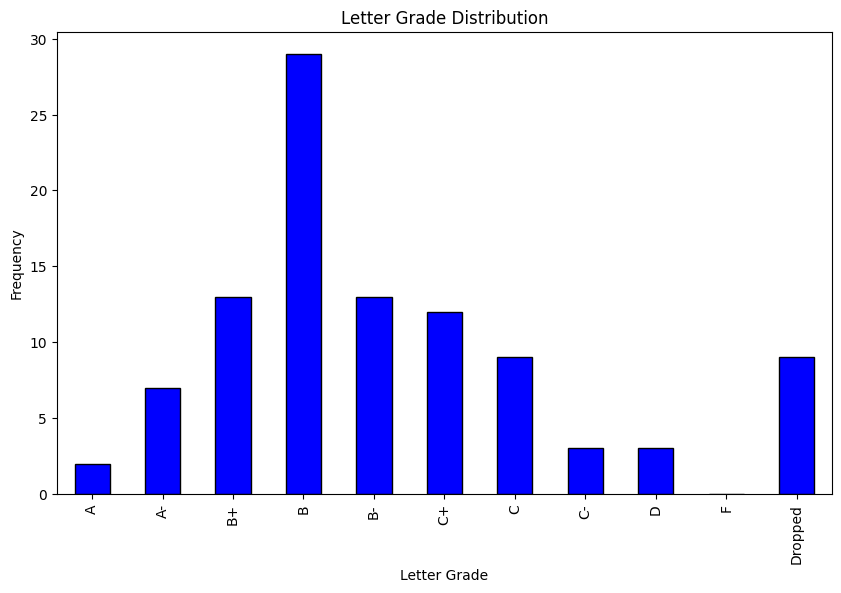

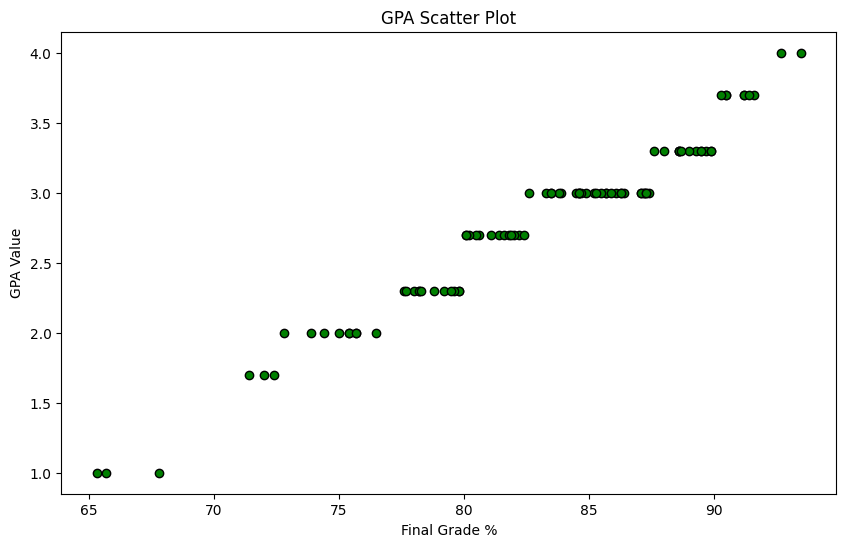

In [72]:
# Function to plot the histogram of letter grades, including dropped students
def plot_letter_grade_histogram(final_gpa_df, title="Letter Grade Distribution"):
    """
    Plots a histogram of letter grades including a category for dropped students,
    reading from the final_gpa_df DataFrame.
    
    Parameters:
    - final_gpa_df: DataFrame containing the final GPA and grade data.
    - title: Title for the plot.
    """
    # Extract the GPA Letter column from the DataFrame
    grade_letters = final_gpa_df['GPA Letter']
    
    # Convert grades to categorical values, ensuring 'Dropped' is included
    grade_letters = pd.Categorical(grade_letters, categories=['A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D', 'F', 'Dropped'], ordered=True)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    grade_counts = grade_letters.value_counts()

    # Sort the value counts based on the predefined order of the categories
    grade_counts = grade_counts.reindex(grade_letters.categories)

    # Create the histogram
    plt.figure(figsize=(10, 6))
    grade_counts.plot(kind='bar', color='blue', edgecolor='black')
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Letter Grade')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Function to plot scatter plot for GPA achieved
def plot_gpa_scatter(final_gpa_df, title="GPA Scatter Plot"):
    """
    Plots a scatter plot showing the achieved GPA for students, reading from the final_gpa_df DataFrame.
    
    Parameters:
    - final_gpa_df: DataFrame containing the final GPA and grade data.
    - title: Title for the scatter plot.
    """
    # Extract the Final Grade % and GPA Value columns from the DataFrame
    final_grades = final_gpa_df['Final Grade %']
    gpa_values = final_gpa_df['GPA Value']
    
    # Filter out rows where GPA is 'Dropped' (non-numeric)
    numeric_gpa = pd.to_numeric(gpa_values, errors='coerce')
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(final_grades, numeric_gpa, color='green', edgecolor='black')
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Final Grade %')
    plt.ylabel('GPA Value')
    
    # Show the plot
    plt.show()

# Use the final_gpa_df directly from the compute_final_gpa function's result
plot_letter_grade_histogram(final_gpa_df)
plot_gpa_scatter(final_gpa_df)